# 2025_SMM748_Group1_GCW2

### 1. Apply PCA to the numerical variables, excluding Year. Summarise and interpretyour key findings.

In [106]:
'''
As ICA heavily depends on conductor's potent of interpreting each component of ICA, we choose to conduct
decomposition.PCA
'''
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from yellowbrick.cluster import SilhouetteVisualizer
from ISLP.cluster import compute_linkage
import numpy as np
import warnings

warnings.filterwarnings('ignore')
df = None
if os.path.exists(os.path.join('data', 'IMDB-Movies.csv')):
    df = pd.read_csv(os.path.join('data', 'IMDB-Movies.csv'), index_col=False)
else:
    df = pd.read_csv('IMDB-Movies.csv', index_col=False)
df.rename(columns={df.columns[0]: 'Rank_by_Rating'}, inplace=True)# First col has noname, so manually do it.

In [21]:
# Basic EDA
# Generate EDA report on raw data using ydata_profiling and save as HTML.
eda_report = ProfileReport(df, title="IMDB-Movies EDA Report (Raw Data)", explorative=True)
eda_report.to_file("IMDB-Movies_eda_raw.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [119]:
'''
As high corr reported between Votes - Revenue..Millions.(0.733),
we can cover up missing data on Revenue..Millions. by vote(by reg)
'''
# backfill by reg with Votes col ---
# --- 결측치 보완 코드 추가: Votes를 이용한 회귀분석 ---
if df['Revenue..Millions.'].isnull().sum() > 0:
    # 결측치가 없는 데이터를 이용하여 회귀모델 학습 (scikit-learn)
    mask_not_missing = df['Revenue..Millions.'].notnull()
    reg = LinearRegression()
    reg.fit(df.loc[mask_not_missing, ['Votes']], df.loc[mask_not_missing, 'Revenue..Millions.'])
    
    # statsmodels를 이용한 회귀모델 진단 (신뢰도 평가)
    X_train = df.loc[mask_not_missing, ['Votes']]
    y_train = df.loc[mask_not_missing, 'Revenue..Millions.']
    X_train_sm = sm.add_constant(X_train)  # 상수항 추가
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    print("p-value:", ols_model.pvalues['Votes'])
    # (전체 요약 결과는 ols_model.summary()로 확인 가능)
    
    # 결측치가 있는 행에 대해 Revenue..Millions. 예측
    mask_missing = df['Revenue..Millions.'].isnull()
    predicted_values = reg.predict(df.loc[mask_missing, ['Votes']])
    
    # 예측한 값을 결측치에 대체
    df.loc[mask_missing, 'Revenue..Millions.'] = predicted_values


# PCA Integration:
# Select features for PCA: 'Rank_by_Rating', 'Runtime..Minutes.', 'Rating', 'Votes', 'Revenue..Millions.'
pca_features = [col for col in df.select_dtypes(include=['int', 'float']).columns if col != 'Year']
X_pca = df[pca_features]

# scale features before PCA
scaler = StandardScaler()
# fit scaler by returns
scaler.fit(X_pca)
# Apply transform scale returns
df_sc = scaler.transform(X_pca)

# Perform PCA on the returns, treating each stock as a feature
n_pca = 5
pca = PCA(n_components=n_pca)  # We'll reduce the dimensionality to 5 components
principal_components = pca.fit_transform(df_sc)

# Create a DataFrame for the principal components with dates as index
pc_df = pd.DataFrame(data=principal_components, index=df.index, columns=[f'PC{n+1}' for n in range(n_pca)])
pc_df.head()

,PC1,PC2,PC3,PC4,PC5
0,4.957390,1.524464,-0.578111,0.310710,0.940782
1,3.844205,0.637410,-0.278740,0.825566,0.323967
2,1.978499,-2.315103,0.514519,-1.107911,0.715483
3,2.781158,-0.085947,0.888772,0.069533,-0.138229
4,0.617123,-2.094361,-1.568042,-0.456231,0.156142


In [122]:
pc_df.head().to_csv('pc_df.csv')

In [117]:
X_pca.columns

Index(['Rank_by_Rating', 'Runtime..Minutes.', 'Rating', 'Votes',
       'Revenue..Millions.'],
      dtype='object')

In [108]:
# Display the proportion of variance explained by each component
print("Explained Variance Ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ratio:.2%}")

Explained Variance Ratio:
PC1: 45.23%
PC2: 28.38%
PC3: 18.47%
PC4: 6.22%
PC5: 1.69%


In [109]:
# Display the loadings (coefficients) for each variable
loadings = pca.components_.T  # Each column corresponds to a PC
# Create a DataFrame for the loadings with tickers as index
loadings_df = pd.DataFrame(data=loadings, index=pca_features, columns=[f'PC{n+1}' for n in range(n_pca)])
print(loadings_df)

                         PC1       PC2       PC3       PC4       PC5
Rank_by_Rating     -0.566875  0.351876  0.221722  0.202814  0.681573
Runtime..Minutes.   0.286654  0.023777  0.928454 -0.234951 -0.005982
Rating              0.594703 -0.295009 -0.184765 -0.052818  0.722752
Votes               0.455684  0.508085  0.028410  0.722383 -0.107510
Revenue..Millions.  0.187517  0.728311 -0.232094 -0.615661  0.038658


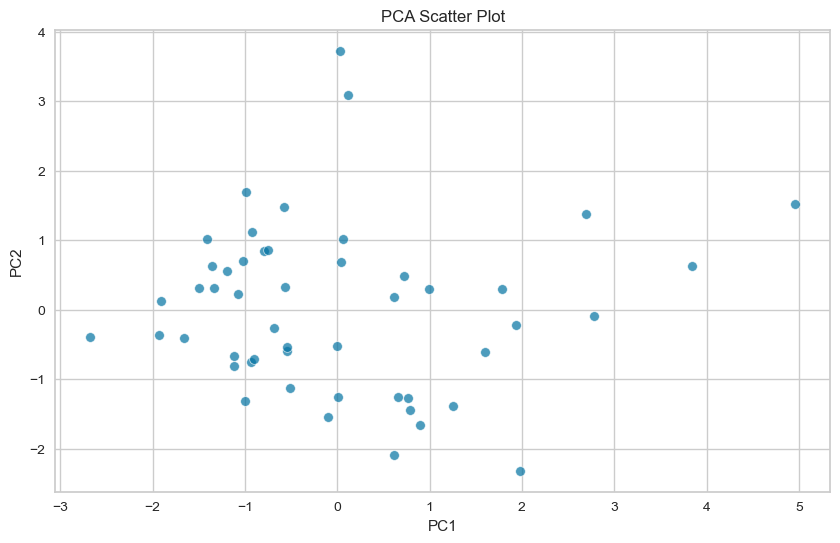

In [110]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pc_df, alpha=0.7)
plt.title('PCA Scatter Plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

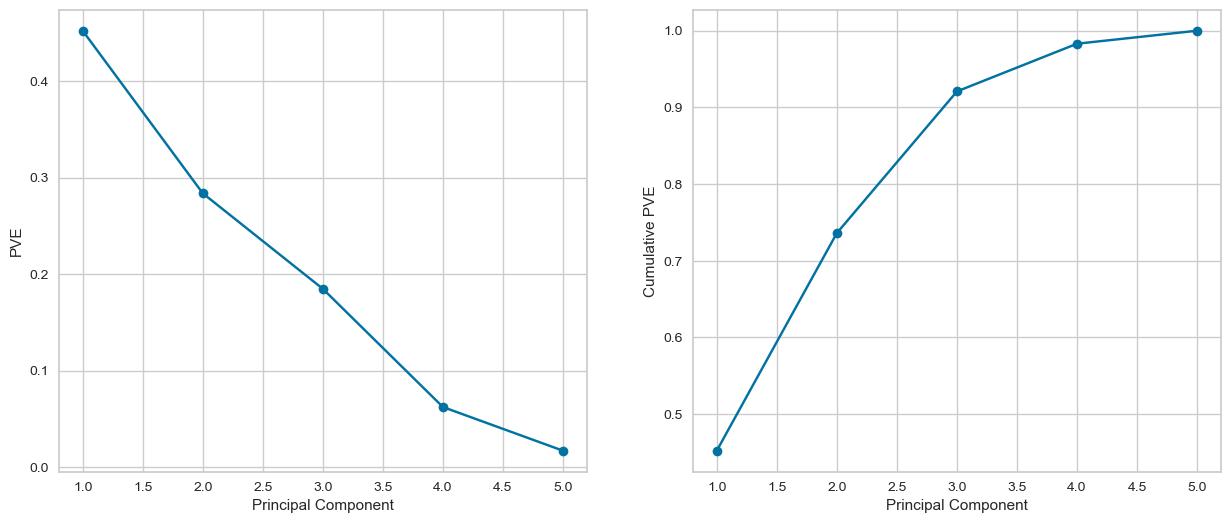

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax = axes[0]
ticks = np.arange(pca.n_components_)+1
ax.plot(ticks,
        pca.explained_variance_ratio_,
        marker='o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('PVE')
ax = axes[1]
ax.plot(ticks,
        pca.explained_variance_ratio_.cumsum(),
        marker='o');
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative PVE');

## 2.Perform clustering on the movies using only the numerical variables, excluding Year.

In [112]:
'''
PCA 를 쓴걸로 하라는건지?
원본 데이터로 하라는건지?
->일단 명시된 조건이면 원본데이터로 하라는 것
'''
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)

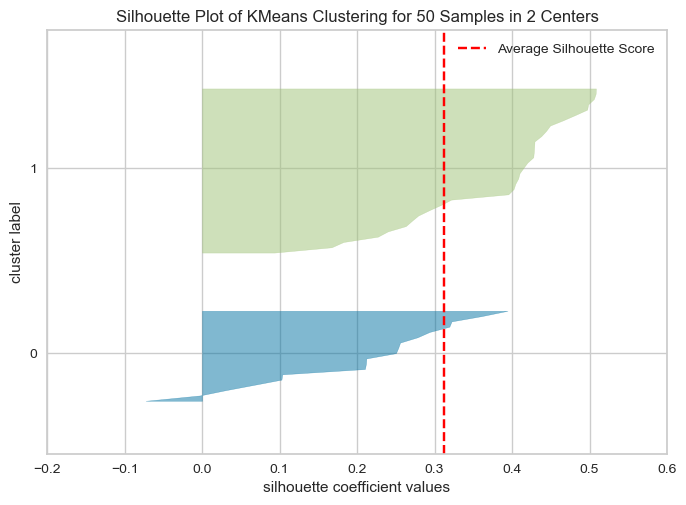

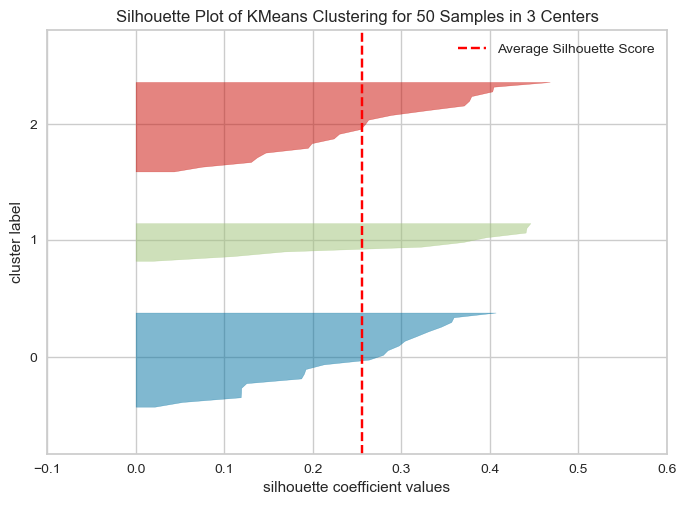

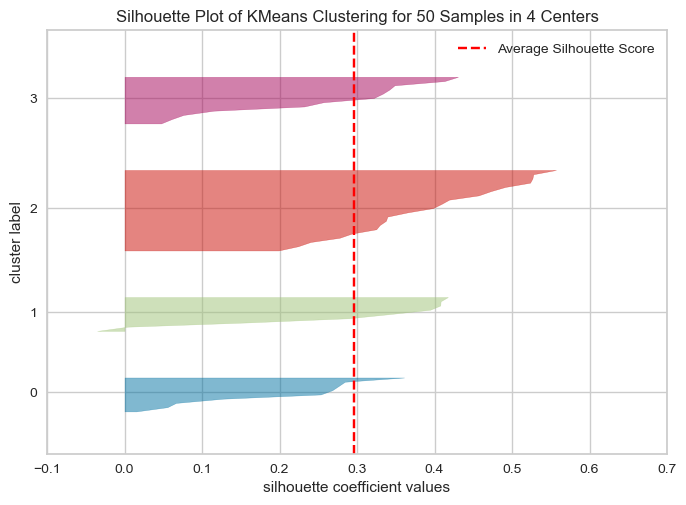

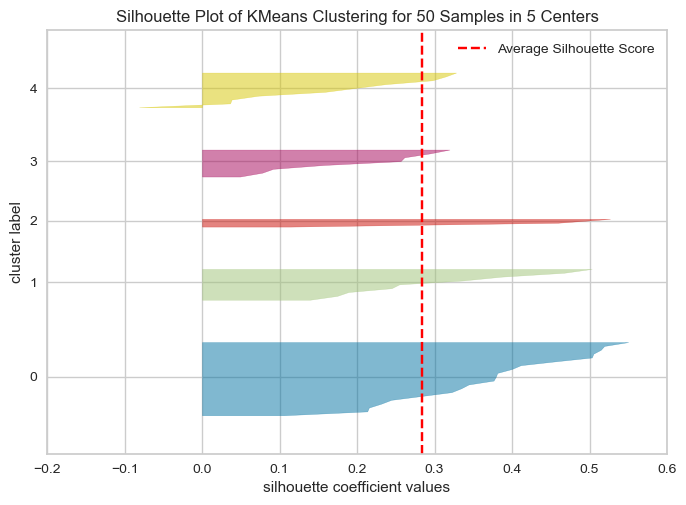

In [101]:
scaler = StandardScaler()
nci_scaled = scaler.fit_transform(X_pca)
for k in range(2, 6):
    model = KMeans(n_clusters=k, random_state=42,n_init=20)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(nci_scaled)
    visualizer.show()

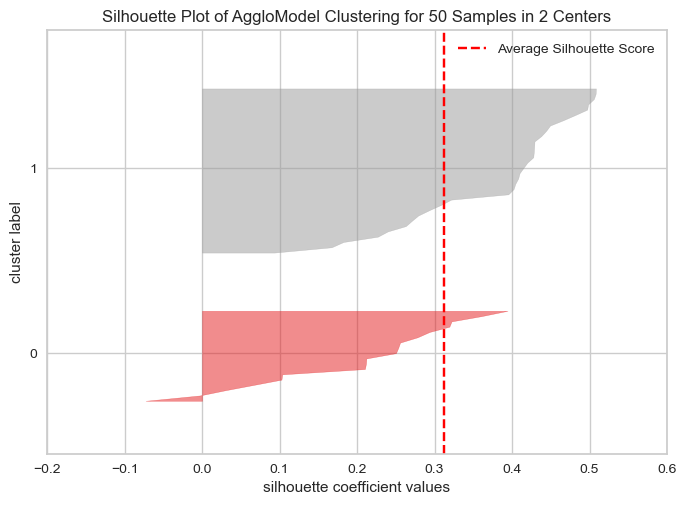

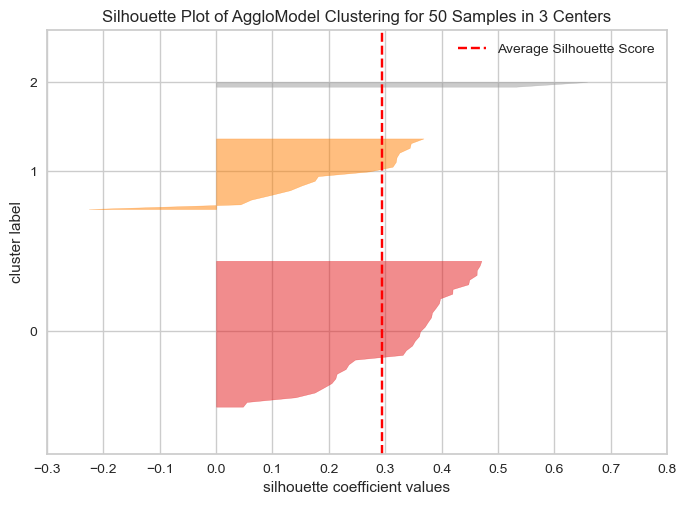

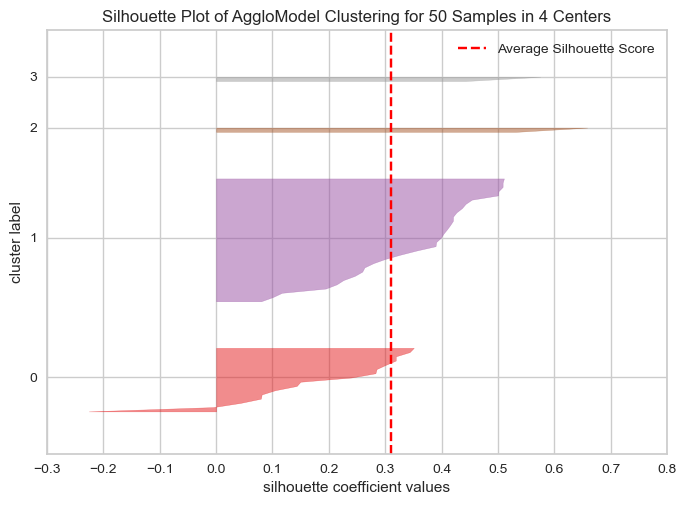

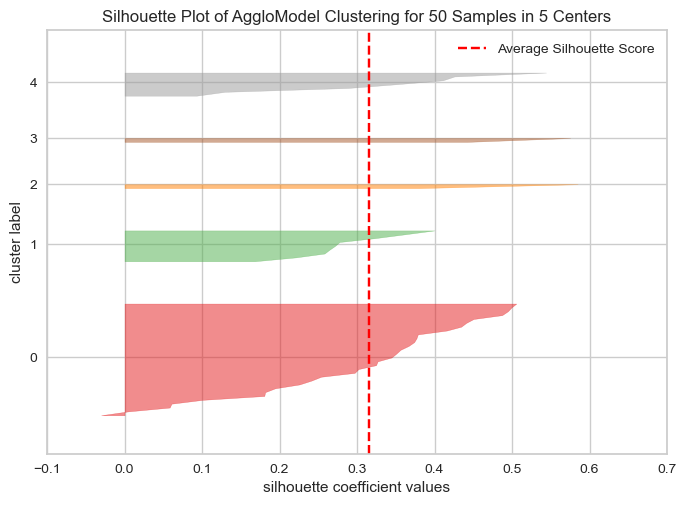

In [114]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import pairwise_distances
from sklearn.base import BaseEstimator, ClusterMixin

# Loop over different numbers of clusters
for n_clusters in range(2, 6):
    # Fit AgglomerativeClustering
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = model.fit_predict(nci_scaled)
    
    # Since SilhouetteVisualizer expects a model with `.fit(X)` & `.predict(X)`,
    # we create a dummy wrapper to plug in our labels
    class AggloModel(BaseEstimator, ClusterMixin):
        def __init__(self, labels, n_clusters):
            self.labels_ = labels
            self.n_clusters = n_clusters

        def fit(self, X, y=None):
            return self

        def predict(self, X):
            return self.labels_

    
    # Visualize silhouette plot
    visualizer = SilhouetteVisualizer(AggloModel(labels, n_clusters))
    visualizer.fit(nci_scaled)
    visualizer.show()

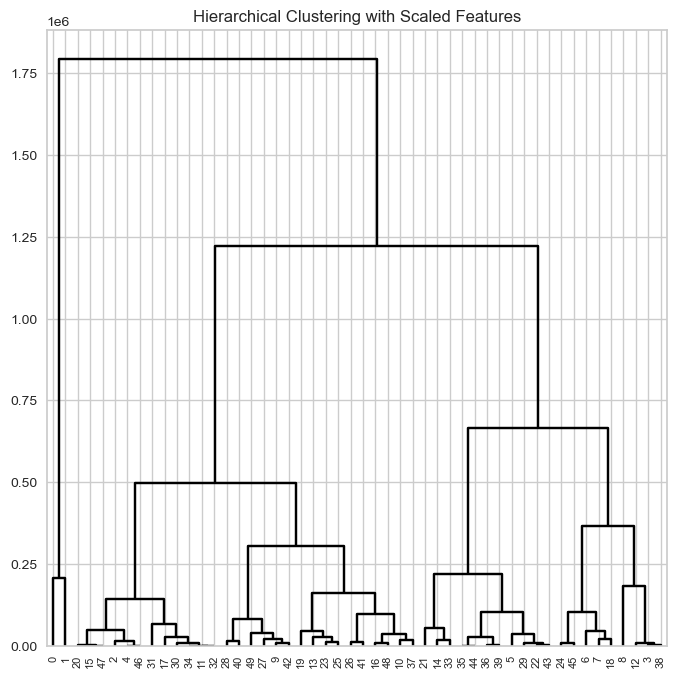

In [124]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
hc_comp_scale = HClust(distance_threshold=0,
                       n_clusters=None,
                       linkage='complete').fit(X_pca)
linkage_comp_scale = compute_linkage(hc_comp_scale)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scale, ax=ax, **cargs)
ax.set_title("Hierarchical Clustering with Scaled Features");